In [455]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

loading data

In [710]:
train=pd.read_csv('/home/xavier/exts-ida/course3/house-prices/house-prices.csv')

In [3]:
train.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
3,142,535152150,20,RL,70.0,10552,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
4,2042,903475060,190,RM,60.0,10120,Pave,NaN,IR1,Bnk,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


In [4]:
print('train data has {0} rows and {1} columns'.format(train.shape[0],train.shape[1]))

train data has 2430 rows and 82 columns


Let's check if the data set has any missing values. 

In [6]:
#check missing values
train.columns[train.isnull().any()]

Index(['Lot Frontage', 'Alley', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Electrical', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',
       'Garage Area', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence',
       'Misc Feature'],
      dtype='object')

Out of 82 features, 27 features have missing values. Let's check the percentage of missing values in these columns.

In [7]:
miss = train.isnull().sum()/len(train)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

Electrical        0.000412
Garage Area       0.000412
Total Bsmt SF     0.000412
Bsmt Unf SF       0.000412
BsmtFin SF 1      0.000412
BsmtFin SF 2      0.000412
Garage Cars       0.000412
Bsmt Full Bath    0.000823
Bsmt Half Bath    0.000823
Mas Vnr Area      0.008230
Mas Vnr Type      0.008230
BsmtFin Type 1    0.029218
Bsmt Qual         0.029218
Bsmt Cond         0.029218
BsmtFin Type 2    0.029630
Bsmt Exposure     0.030453
Garage Type       0.055967
Garage Finish     0.056790
Garage Qual       0.056790
Garage Cond       0.056790
Garage Yr Blt     0.056790
Lot Frontage      0.172840
Fireplace Qu      0.488066
Fence             0.798765
Alley             0.932922
Misc Feature      0.962963
Pool QC           0.995062
dtype: float64

separating numeric and categorical variables

In [8]:
numeric_hdata = train.select_dtypes(include=[np.number])
cat_hdata = train.select_dtypes(exclude=[np.number])
print ('There are {} numeric and {} categorical columns in train data'.format(numeric_hdata.shape[1],cat_hdata.shape[1]))

There are 39 numeric and 43 categorical columns in train data


removing the PID and Order variables from numeric data

In [9]:
del numeric_hdata['PID']
del numeric_hdata['Order']

Interesting to learn about the correlation behaviour of numeric variables

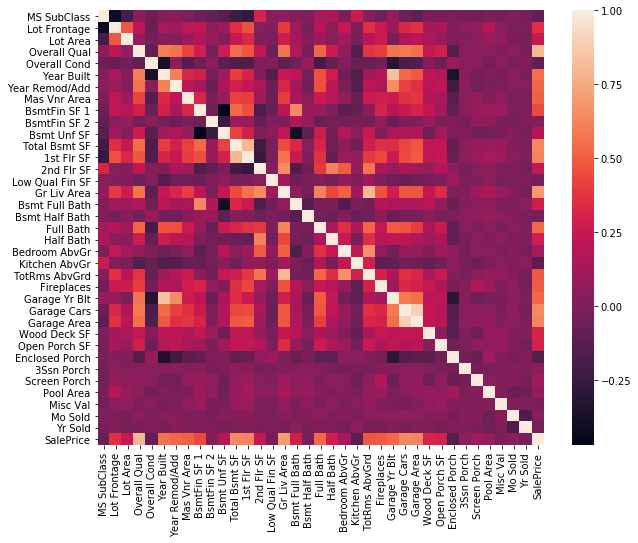

In [10]:
%matplotlib inline
plt.rcParams['figure.figsize']=(10.0,8.0)
corr = numeric_hdata.corr()
sns.heatmap(corr)

We don't have a lot of correlation between the variables.Year Built-Garage Yr Blt, Gr liv Area-TotRms AbvGrd,
Garage Cars-Garage Area, Total Bsmt SF-1st Flr SF, have fairly strong correlations; but we will keep them anyway for the rest of our study

In [11]:
print (corr['SalePrice'].sort_values(ascending=False)[:15], '\n') #top 15 values
print ('----------------------')
print (corr['SalePrice'].sort_values(ascending=False)[-5:]) #last 5 values`

SalePrice         1.000000
Overall Qual      0.799022
Gr Liv Area       0.700147
Garage Cars       0.643467
Total Bsmt SF     0.635329
Garage Area       0.630807
1st Flr SF        0.625882
Year Built        0.559823
Full Bath         0.536616
Garage Yr Blt     0.530062
Year Remod/Add    0.528243
Mas Vnr Area      0.509386
Fireplaces        0.492056
TotRms AbvGrd     0.483882
BsmtFin SF 1      0.439591
Name: SalePrice, dtype: float64 

----------------------
Low Qual Fin SF   -0.029989
MS SubClass       -0.087456
Overall Cond      -0.102353
Kitchen AbvGr     -0.119954
Enclosed Porch    -0.138282
Name: SalePrice, dtype: float64


Here we see that the OverallQual feature is 79% correlated with the target variable. Overallqual feature refers to the overall material and quality of the materials of the completed house. Well, this make sense as well. People usually consider these parameters for their dream house. In addition, GrLivArea is 70% correlated with the target variable. GrLivArea refers to the living area (in sq ft.) above ground. The following variables show people also care about if the house has a garage, the area of that garage, the size of the basement area, etc. 

###### checking features correlated with SalePrice

Checking 'Over Qual' feature

In [13]:
train['Overall Qual'].unique()

array([ 7,  6,  4,  5,  8,  9, 10,  3,  1,  2], dtype=int64)

The overall quality is measured on a scale of 1 to 10. Hence, we can fairly treat it as an ordinal variable.We are using median because the target variable is skewed. A skewed variable has outliers and median is robust to outliers.<br><br>


Checking 'Gr Liv Area' variable

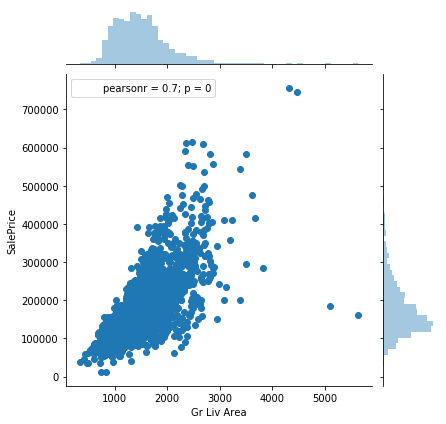

In [19]:
#GrLivArea variable
sns.jointplot(x=train['Gr Liv Area'], y=train['SalePrice'])

Checking 'Garage Cars' variable

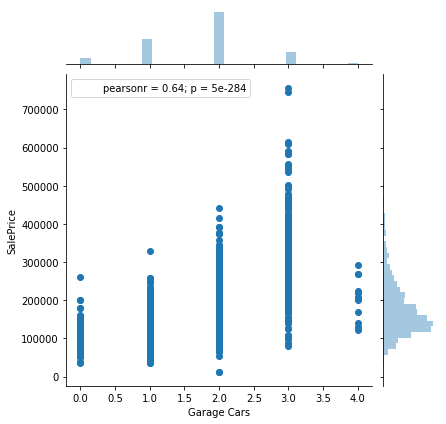

In [21]:
#Garage Cars variable
sns.jointplot(x=train['Garage Cars'], y=train['SalePrice'])

Checking 'Total Bsmt SF' variable

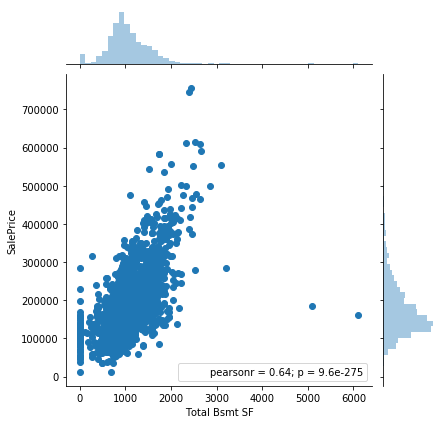

In [22]:
#Total Bsmt SF variable
sns.jointplot(x=train['Total Bsmt SF'], y=train['SalePrice'])

Checking 'Garage Area' variable

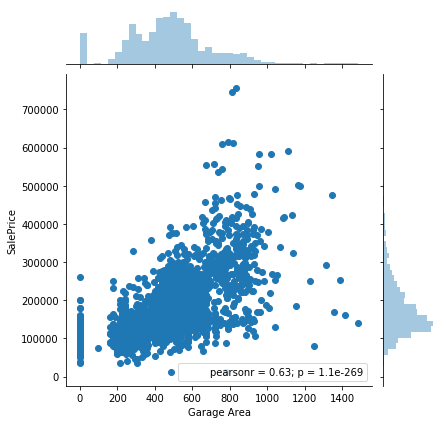

In [23]:
#Garage Area variable
sns.jointplot(x=train['Garage Area'], y=train['SalePrice'])

Checking '1st Flr SF' variable

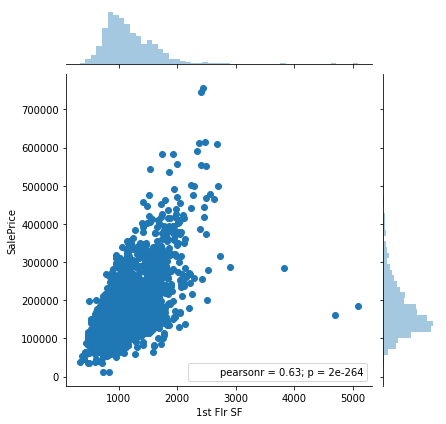

In [25]:
#1st Flr SF variable
sns.jointplot(x=train['1st Flr SF'], y=train['SalePrice'])

Checking 'Year Built' variable

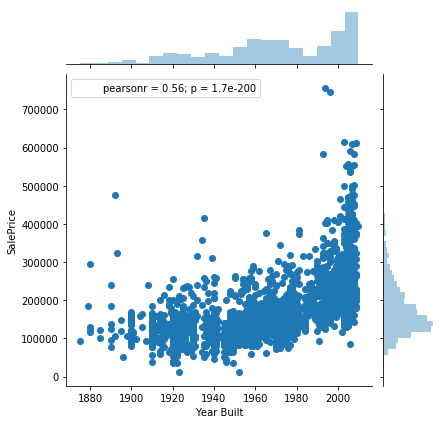

In [26]:
#Year Built variable
sns.jointplot(x=train['Year Built'], y=train['SalePrice'])

Checking 'Full Bath' variable

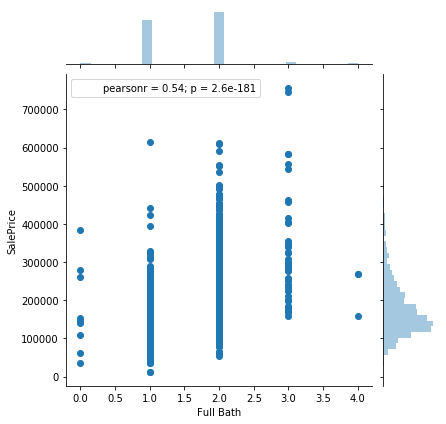

In [27]:
#Full Bath variable
sns.jointplot(x=train['Full Bath'], y=train['SalePrice'])

Checking 'Garage Yr Blt' variable

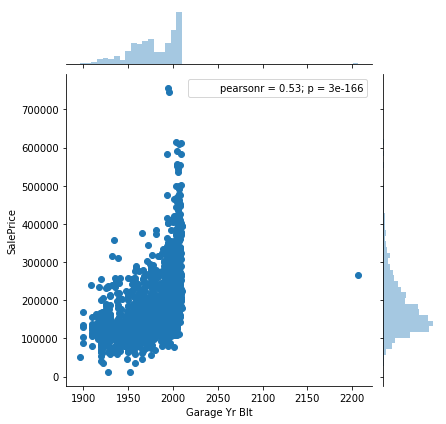

In [28]:
#Garage Yr Blt variable
sns.jointplot(x=train['Garage Yr Blt'], y=train['SalePrice'])

Checking 'Year Remod/Add'

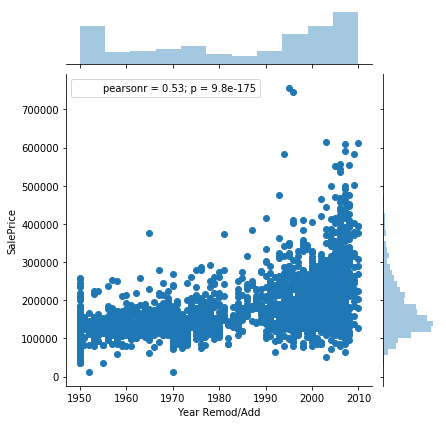

In [29]:
#Year Remod/Add variable
sns.jointplot(x=train['Year Remod/Add'], y=train['SalePrice'])

Checking 'Mas Vnr Area' variable

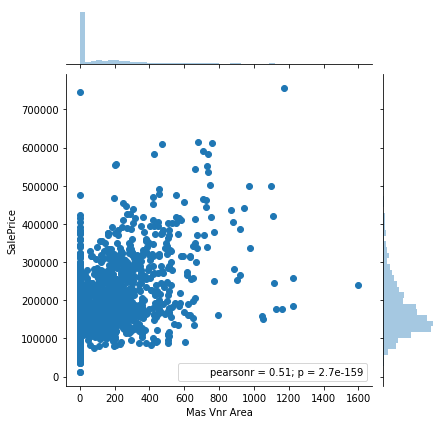

In [30]:
#Mas Vnr Area variable
sns.jointplot(x=train['Mas Vnr Area'], y=train['SalePrice'])

### DATA PREPROCESING

### Data Cleaning

In [711]:
#Removing outliers
train.drop(train[train['Gr Liv Area']>4000].index,inplace=True)
train.drop(train[train['Total Bsmt SF']>3000].index,inplace=True)
train.drop(train[train['Garage Area']>1050].index,inplace=True)
train.drop(train[train['1st Flr SF']>3000].index,inplace=True)
train.drop(train[train['Garage Yr Blt']>2050].index,inplace=True)
train.drop(train[train['Mas Vnr Area']>800].index,inplace=True)
train.shape

(2389, 82)

deleting 'PID' and 'Order' features

In [712]:
del train['PID']
del train['Order']

imputing 'lot frontage' by median of 'neighborhood'

In [713]:
lot_frontage_by_neighborhood = train['Lot Frontage'].groupby(train['Neighborhood'])

for key, group in lot_frontage_by_neighborhood:
                idx = (train['Neighborhood'] == key) & (train['Lot Frontage'].isnull())
                train.loc[idx, 'Lot Frontage'] = group.median()

Imputing other numeric variables

In [714]:
#imputing missing values
train["Mas Vnr Area"].fillna(0, inplace=True)
train["Garage Area"].fillna(0, inplace=True)
train["Total Bsmt SF"].fillna(0, inplace=True)
train["BsmtFin SF 1"].fillna(0, inplace=True)
train["BsmtFin SF 2"].fillna(0, inplace=True)
train["Garage Cars"].fillna(0, inplace=True)
train["Bsmt Full Bath"].fillna(0, inplace=True)
train["Bsmt Half Bath"].fillna(0, inplace=True)
train["Bsmt Unf SF"].fillna(0, inplace=True)
train["Garage Yr Blt"].fillna(np.nanmedian(train["Garage Yr Blt"]), inplace=True)
train["Lot Frontage"].fillna(0, inplace=True)

Visualizing data in ordinal features

In [35]:
print('Exter Qual')
print(train["Exter Qual"].value_counts())
print('-----------')
print('Pool QC')
print(train["Pool QC"].value_counts())
print('-----------')
print('Exter Cond')
print(train["Exter Cond"].value_counts())
print('-----------')
print('Bsmt Qual')
print(train["Bsmt Qual"].value_counts())
print('-----------')
print('Heating QC')
print(train["Heating QC"].value_counts())
print('-----------')
print('Kitchen Qual')
print(train["Kitchen Qual"].value_counts())
print('-----------')
print('FireplaceQu')
print(train["Fireplace Qu"].value_counts())
print('-----------')
print('Garage Qual')
print(train["Garage Qual"].value_counts())
print('-----------')
print('Garage Cond')
print(train["Garage Cond"].value_counts())
print('-----------')

Exter Qual
TA    1488
Gd     798
Ex      73
Fa      30
Name: Exter Qual, dtype: int64
-----------
Pool QC
Ex    3
TA    3
Gd    2
Fa    2
Name: Pool QC, dtype: int64
-----------
Exter Cond
TA    2073
Gd     247
Fa      54
Ex      12
Po       3
Name: Exter Cond, dtype: int64
-----------
Bsmt Qual
TA    1057
Gd     992
Ex     194
Fa      75
Po       1
Name: Bsmt Qual, dtype: int64
-----------
Heating QC
Ex    1195
TA     713
Gd     398
Fa      81
Po       2
Name: Heating QC, dtype: int64
-----------
Kitchen Qual
TA    1231
Gd     942
Ex     157
Fa      58
Po       1
Name: Kitchen Qual, dtype: int64
-----------
FireplaceQu
Gd    596
TA    469
Fa     66
Po     42
Ex     33
Name: Fireplace Qu, dtype: int64
-----------
Garage Qual
TA    2118
Fa     108
Gd      18
Po       5
Ex       2
Name: Garage Qual, dtype: int64
-----------
Garage Cond
TA    2162
Fa      61
Po      14
Gd      12
Ex       2
Name: Garage Cond, dtype: int64
-----------


Variable names which have 'quality' or 'qual' in their names are ordinal variables.we'll simply create a dictionary of key-value pairs and map it to the variable in the data set.

In [715]:
def encode_ordinal(df):
    #df = pd.DataFrame(index = df.index)
    qual_dict = {np.nan:0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
    name = np.array(['Exter Qual','Pool QC','Exter Cond','Bsmt Qual','Bsmt Cond'])
    for i in name:
        df[i] = df[i].map(qual_dict).astype(int)
        qual_dict = {np.nan:0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
        
        colname = np.array(['Fireplace Qu', 'Garage Qual','Garage Cond'])
        for i in colname:
            df[i] = df[i].map(qual_dict).astype(int)
            df["Bsmt Exposure"] = df["Bsmt Exposure"].map({np.nan: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)
            bsmt_fin_dict = {np.nan: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
            df["BsmtFin Type 1"] = df["BsmtFin Type 1"].map(bsmt_fin_dict).astype(int)
            df["BsmtFin Type 2"] = df["BsmtFin Type 2"].map(bsmt_fin_dict).astype(int)
            df["Functional"] = df["Functional"].map({np.nan: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)
            df["Garage Finish"] = df["Garage Finish"].map({np.nan: 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)
            df["Fence"] = df["Fence"].map({np.nan: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)
            df["Central Air"] = (df["Central Air"] == "Y") * 1.0
            
            return df

we'll encode all the categorical variables. This is necessary because most ML algorithms do not accept categorical values, instead they are expected to be converted to numerical. LabelEncoder function from sklearn is used to encode variables: 

In [716]:
#importing function
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def factorize(data, var, fill_na = None):
    if fill_na is not None:
        data[var].fillna(fill_na, inplace=True)
        le.fit(data[var])
        data[var] = le.transform(data[var])
        return data

In [717]:
def cat_enc(cat_df):
    varst = np.array(['MS SubClass','Lot Config','Neighborhood','Condition 1','Bldg Type','House Style','Roof Style','Foundation','Sale Condition'])
    for x in varst:
        factorize(cat_df, x)
        #encode variables and impute missing values
        cat_df = factorize(cat_df, 'Mas Vnr Type', "None")
        return cat_df

## FEATURE ENGINEERING

Most categorical variables have near-zero variance distribution. Near-zero variance distribution is when one of the categories in a variable has >90% of the values. We'll create some binary variables depicting the presence or absence of a category. The new features will contain 0 or 1 values. In addition, we'll create some more variables which are self-explanatory with comments. 

In [718]:
def feat_col(feat_df):
   # feat_df = pd.DataFrame(index = df.index)
    
    #creating new variable (1 or 0) based on irregular count levels
    #The level with highest count is kept as 1 and rest as 0
    feat_df["IsRegularLotShape"] = (feat_df["Lot Shape"] == "Reg") * 1
    feat_df["IsLandLevel"] = (feat_df["Land Contour"] == "Lvl") * 1
    feat_df["IsLandSlopeGentle"] = (feat_df["Land Slope"] == "Gtl") * 1
    feat_df["IsElectricalSBrkr"] = (feat_df["Electrical"] == "SBrkr") * 1
    feat_df["IsGarageDetached"] = (feat_df["Garage Type"] == "Detchd") * 1
    feat_df["IsPavedDrive"] = (feat_df["Paved Drive"] == "Y") * 1
    feat_df["HasShed"] = (feat_df["Misc Feature"] == "Shed") * 1
    feat_df["Remodeled"] = (feat_df['Year Remod/Add'] != feat_df["Year Built"]) * 1
    #Did the modeling happen during the sale year?
    feat_df["RecentRemodel"] = (feat_df["Year Remod/Add"] == feat_df["Yr Sold"]) * 1
    # Was this house sold in the year it was built?
    feat_df["VeryNewHouse"] = (feat_df["Year Built"] == feat_df["Yr Sold"]) * 1
    feat_df["Has2ndFloor"] = (feat_df["2nd Flr SF"] == 0) * 1
    feat_df["HasMasVnr"] = (feat_df["Mas Vnr Area"] == 0) * 1
    feat_df["HasWoodDeck"] = (feat_df["Wood Deck SF"] == 0) * 1
    feat_df["HasOpenPorch"] = (feat_df["Open Porch SF"] == 0) * 1
    feat_df["HasEnclosedPorch"] = (feat_df["Enclosed Porch"] == 0) * 1
    feat_df["Has3SsnPorch"] = (feat_df["3Ssn Porch"] == 0) * 1
    feat_df["HasScreenPorch"] = (feat_df["Screen Porch"] == 0) * 1
    #setting levels with high count as 1 and the rest as 0
    #we can check for them using the value_counts function
    feat_df["HighSeason"] = feat_df["Mo Sold"].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
    feat_df["NewerDwelling"] = feat_df["MS SubClass"].replace({20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})
    
    #Just like Garage, we have several columns associated with the area of the property. 
    #An interesting variable could be the sum of all areas for a particular house. In addition, we can also create new features based on the year the house built. 

    #calculating total area using all area columns
    area_cols = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF','Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Garage Area', 'Wood Deck SF','Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Low Qual Fin SF', 'Pool Area' ]
    
    feat_df["TotalArea"] = feat_df[area_cols].sum(axis=1)
    feat_df["TotalArea1st2nd"] = feat_df["1st Flr SF"] + feat_df["2nd Flr SF"]
    feat_df["Age"] = 2020 - feat_df["Year Built"]
    feat_df["TimeSinceSold"] = 2020 - feat_df["Yr Sold"]
    feat_df["SeasonSold"] = train["Mo Sold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
    feat_df["YearsSinceRemodel"] = feat_df["Yr Sold"] - feat_df["Year Remod/Add"]
    # Simplifications of existing features into bad/average/good based on counts
    feat_df["SimplOverallQual"] = feat_df['Overall Qual'].map({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3}).astype(int)
    feat_df["SimplOverallCond"] = feat_df['Overall Cond'].replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    feat_df["SimplPoolQC"] = feat_df['Pool QC'].replace({1 : 1, 2 : 1, 3 : 2, 4 : 2})
    feat_df["SimplGarageCond"] = feat_df['Garage Cond'].replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    feat_df["SimplGarageQual"] = feat_df['Garage Qual'].replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    feat_df["SimplFireplaceQu"] = feat_df['Fireplace Qu'].replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    feat_df["SimplFunctional"] = feat_df['Functional'].replace({1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
    feat_df["SimplKitchenQual"] = feat_df['Kitchen Qual'].replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    feat_df["SimplHeatingQC"] = feat_df['Heating QC'].replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    feat_df["SimplBsmtFinType1"] = feat_df['BsmtFin Type 1'].replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    feat_df["SimplBsmtFinType2"] = feat_df['BsmtFin Type 2'].replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    feat_df["SimplBsmtCond"] = feat_df['Bsmt Cond'].replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    feat_df["SimplBsmtQual"] = feat_df['Bsmt Qual'].replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    feat_df["SimplExterCond"] = feat_df['Exter Cond'].replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    feat_df["SimplExterQual"] = feat_df['Exter Qual'].replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    return feat_df

we one-hot encode the categorical variable.

In [719]:
def onehot(onehot_df, df, column_name, fill_na):
    onehot_df[column_name] = df[column_name]
    if fill_na is not None:
        onehot_df[column_name].fillna(fill_na, inplace=True)
        dummies = pd.get_dummies(onehot_df[column_name], prefix="_"+column_name)
        onehot_df = onehot_df.join(dummies)
        onehot_df = onehot_df.drop([column_name], axis=1)
        return onehot_df

In [720]:
def train_onehot(df):
    onehot_df = pd.DataFrame(index = df.index)
    onehot_df = onehot(onehot_df, df, "MS SubClass", "None")
    onehot_df = onehot(onehot_df, df, "MS Zoning", "None")
    onehot_df = onehot(onehot_df, df, "Lot Config", "None")
    onehot_df = onehot(onehot_df, df, "Neighborhood", "None")
    onehot_df = onehot(onehot_df, df, "Condition 1", "None")
    onehot_df = onehot(onehot_df, df, "Bldg Type", "None")
    onehot_df = onehot(onehot_df, df, "House Style", "None")
    onehot_df = onehot(onehot_df, df, "Roof Style", "None")
    onehot_df = onehot(onehot_df, df, "Exterior 1st", "None")
    onehot_df = onehot(onehot_df, df, "Exterior 2nd", "None")
    onehot_df = onehot(onehot_df, df, "Foundation","None")
    onehot_df = onehot(onehot_df, df, "Sale Type", "None")
    onehot_df = onehot(onehot_df, df, "Sale Condition", "None")
    onehot_df = onehot(onehot_df, df, "Lot Shape", "None")
    onehot_df = onehot(onehot_df, df, "Land Contour", "None")
    onehot_df = onehot(onehot_df, df, "Land Slope", "None")
    onehot_df = onehot(onehot_df, df, "Electrical", "SBrkr")
    onehot_df = onehot(onehot_df, df, "Garage Type","Attchd") 
    onehot_df = onehot(onehot_df, df, "Paved Drive", "None")
    onehot_df = onehot(onehot_df, df, "Misc Feature","Shed")
    onehot_df = onehot(onehot_df, df, "Street", "None")
    onehot_df = onehot(onehot_df, df, "Alley","Grvl")
    onehot_df = onehot(onehot_df, df, "Condition 2", "None")
    onehot_df = onehot(onehot_df, df, "Roof Matl", "None")
    onehot_df = onehot(onehot_df, df, "Heating", "None")

    # we'll have these as numerical variables too
    onehot_df = onehot(onehot_df, df, "Exter Qual", "None")
    onehot_df = onehot(onehot_df, df, "Exter Cond", "None")
    onehot_df = onehot(onehot_df, df, "Bsmt Qual", "TA")
    onehot_df = onehot(onehot_df, df, "Bsmt Cond", "TA")
    onehot_df = onehot(onehot_df, df, "Heating QC", "None")
    onehot_df = onehot(onehot_df, df, "Kitchen Qual", "None")
    onehot_df = onehot(onehot_df, df, "Fireplace Qu", "Gd")
    onehot_df = onehot(onehot_df, df, "Garage Qual", 'TA')
    onehot_df = onehot(onehot_df, df, "Garage Cond", 'TA')
    onehot_df = onehot(onehot_df, df, "Pool QC", "TA")
    onehot_df = onehot(onehot_df, df, "Bsmt Exposure", "No")
    onehot_df = onehot(onehot_df, df, "BsmtFin Type 1", "Unf")
    onehot_df = onehot(onehot_df, df, "BsmtFin Type 2", "Unf")
    onehot_df = onehot(onehot_df, df, "Functional", "None")
    onehot_df = onehot(onehot_df, df, "Garage Finish", "Unf")
    onehot_df = onehot(onehot_df, df, "Fence", "MnPrv")
    onehot_df = onehot(onehot_df, df, "Mo Sold", "None")

    return onehot_df

In [721]:
label_df = pd.DataFrame(index = train.index, columns = ['SalePrice'])
label_df['SalePrice'] = np.log10(train['SalePrice'])

In [722]:
#deleting SalePrice variable in train data
del train['SalePrice']

encoding , feature engineering

In [723]:
train = encode_ordinal(train)
train = cat_enc(train)
train = feat_col(train)

In [724]:
onehot_df = train_onehot(train)

In [725]:
train = train.join(onehot_df)

In [726]:
train.shape

(2389, 407)

In [603]:
miss = train.isnull().sum()/len(train)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

Electrical         0.000419
Bsmt Qual          0.029301
Bsmt Cond          0.029301
SimplBsmtCond      0.029301
SimplBsmtQual      0.029301
Garage Type        0.056928
Garage Qual        0.057765
Garage Cond        0.057765
SimplGarageCond    0.057765
SimplGarageQual    0.057765
Alley              0.933026
Misc Feature       0.963165
Pool QC            0.995814
SimplPoolQC        0.995814
dtype: float64

According to reference,numeric features are skewed;i'll transform them and remove their skewness

In [727]:
#get numeric features
numeric_features = [f for f in train.columns if train[f].dtype != object]

#transform the numeric features using log(x + 1)
from scipy.stats import skew
skewed = train[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
train[skewed] = np.log1p(train[skewed])

Standardizing the numeric features

In [728]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train[numeric_features])
scaled = scaler.transform(train[numeric_features])

In [729]:
train_pred = train.select_dtypes(include=[np.number])
train_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2389 entries, 0 to 2429
Columns: 366 entries, MS SubClass to _Mo Sold_12
dtypes: float64(284), int32(20), int64(18), uint8(44)
memory usage: 5.9 MB


## Model

### intermediate

Choosing significant feature for our study

In [312]:
col_intermediate=['Garage Cars', 'Bsmt Full Bath','SeasonSold','YearsSinceRemodel','Age', 'TotalArea1st2nd', 'TotalArea',
                  'SimplOverallQual', 'SimplOverallCond','IsElectricalSBrkr', 'IsPavedDrive', 'VeryNewHouse','Remodeled']

In [313]:
train_intermediate = train_pred[col_intermediate]

In [314]:
from sklearn.model_selection import train_test_split
X_tr,X_te,y_tr,y_te = train_test_split(train_intermediate,label_df['SalePrice'],train_size=0.5,test_size=0.5,random_state=0)

In [191]:
# Define a set of alpha values
alphas = np.logspace(-10, 0, num=100)

#save score
test_scores = []

In [192]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error as mse
# Grid search
for alpha in alphas:
    # Ridge regression
    ridge = Ridge(alpha)
    ridge.fit(X_tr, y_tr)

In [193]:
# Test score
y_pred = ridge.predict(X_te)
test_scores.append(mse(y_te, y_pred))

In [195]:
# Find best alpha
idx = np.argmin(test_scores)
best_alpha = alphas[idx]
print('Best alpha :',best_alpha)

Best alpha : 1e-10


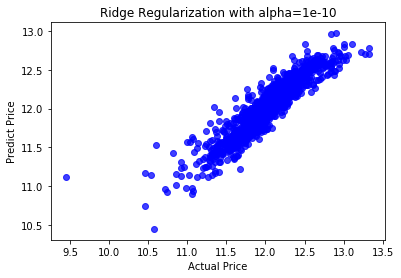

In [196]:
from sklearn import linear_model
%matplotlib inline
import matplotlib.pyplot as plt

rm = linear_model.Ridge(alpha=best_alpha)
ridge_model = rm.fit(X_tr,y_tr)
preds_ridge = ridge_model.predict(X_te)
plt.scatter(y_te,preds_ridge,alpha=.75,color='b')

plt.xlabel('Actual Price')
plt.ylabel('Predict Price')
plt.title('Ridge Regularization with alpha={}'.format(best_alpha))
plt.show()

### Complex

In [197]:
from sklearn.model_selection import train_test_split
X_tr,X_te,y_tr,y_te = train_test_split(train_pred,label_df['SalePrice'],train_size=0.5,test_size=0.5,random_state=0)

In [198]:
# Define a set of alpha values
alphas = np.logspace(-10, 0, num=100)

# save score
test_scores = []

In [199]:
# Grid search
for alpha in alphas:
    # Ridge regression
    ridge = Ridge(alpha)
  #  ridge.fit(X_tr, y_tr)
    ridge.fit(X_tr, y_tr)

/home/xavier/anaconda3/envs/exts-aml1/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.121223599707731e-19 / 1.1102230246251565e-16
  RuntimeWarning)
/home/xavier/anaconda3/envs/exts-aml1/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.683315682262057e-19 / 1.1102230246251565e-16
  RuntimeWarning)
/home/xavier/anaconda3/envs/exts-aml1/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6393734514215265e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/home/xavier/anaconda3/envs/exts-aml1/lib/python3.6/site-packages/scipy/linalg/basic

In [200]:
# Test score
y_pred = ridge.predict(X_te)
test_scores.append(mse(y_te, y_pred))

In [202]:
# Find best alpha
idx = np.argmin(test_scores)
best_alpha = alphas[idx]
print('Best alpha :',best_alpha)

Best alpha : 1e-10


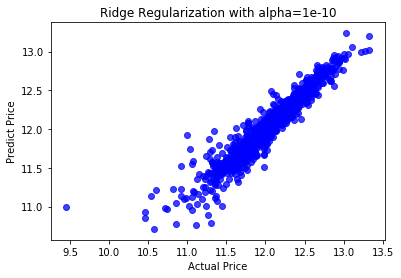

In [203]:
from sklearn import linear_model
%matplotlib inline
import matplotlib.pyplot as plt

rm = linear_model.Ridge(alpha=best_alpha)
ridge_model = rm.fit(X_tr,y_tr)
preds_ridge = ridge_model.predict(X_te)
plt.scatter(y_te,preds_ridge,alpha=.75,color='b')

plt.xlabel('Actual Price')
plt.ylabel('Predict Price')
plt.title('Ridge Regularization with alpha={}'.format(best_alpha))
plt.show()

## Model Evaluation

In [204]:
def MAE(y,y_pred):
    return np.mean(np.abs(y-y_pred))

In [205]:
def RMSLE(y,y_pred):
    return np.sqrt(np.mean(np.square(y-y_pred)))

### Simple

In [206]:
col_simple = ['TotalArea','VeryNewHouse']
train_simple = train_pred[col_simple]

In [207]:
from sklearn.model_selection import train_test_split
X_tr,X_te,y_tr,y_te = train_test_split(train_simple,label_df['SalePrice'],train_size=0.5,test_size=0.5,random_state=0)

In [208]:
from sklearn.linear_model import LinearRegression
lrs = LinearRegression()
lrs.fit(X_tr,y_tr)
y_pred_te = lrs.predict(X_te)
lr_rmlse_te = RMSLE(y_te, y_pred_te)
print('RMSLE Simple is:\n',lr_rmlse_te)

RMSLE Simple is:
 0.3418290193739365


In [209]:
from sklearn.linear_model import LinearRegression

# Function to fit a linear regression
def fit_lr(X_train, y_train, X_test):
    # Create a linear regression
    lrs = LinearRegression()
    
    # Fit it to train data
    lrs.fit(X_train, y_train)
    
    # Compute predictions for test set
    y_pred = lrs.predict(X_test)
    return y_pred

In [210]:
# Linear regression
y_pred = fit_lr(X_tr, y_tr, X_te)
mae_lr_simple = MAE(y_te, y_pred)
print('MAE Simple:\n',mae_lr_simple)

MAE Simple:
 0.25442986773951204


### Intermediate

In [211]:
col_intermediate=['Garage Cars', 'Bsmt Full Bath','SeasonSold','YearsSinceRemodel','Age', 'TotalArea1st2nd', 'TotalArea',
                  'SimplOverallQual', 'SimplOverallCond','IsElectricalSBrkr', 'IsPavedDrive', 'VeryNewHouse','Remodeled']

In [212]:
train_intermediate = train_pred[col_intermediate]

In [213]:
from sklearn.model_selection import train_test_split
X_tr,X_te,y_tr,y_te = train_test_split(train_intermediate,label_df['SalePrice'],train_size=0.5,test_size=0.5,random_state=0)

In [214]:
from sklearn.linear_model import LinearRegression
lri = LinearRegression()
lri.fit(X_tr,y_tr)
y_pred_te = lri.predict(X_te)
lr_rmlse_te = RMSLE(y_te, y_pred_te)
print('RMSLE Intermediate is:\n',lr_rmlse_te)

RMSLE Intermediate is:
 0.1618736193225331


In [215]:
from sklearn.linear_model import LinearRegression

# Function to fit a linear regression
def fit_lr(X_train, y_train, X_test):
    # Create a linear regression
    lri = LinearRegression()
    
    # Fit it to train data
    lri.fit(X_train, y_train)
    
    # Compute predictions for test set
    y_pred = lri.predict(X_test)
    return y_pred

In [216]:
# Linear regression
y_pred = fit_lr(X_tr, y_tr, X_te)
mae_lr_intermediate = MAE(y_te, y_pred)
print('MAE Intermediate:\n',mae_lr_intermediate)

MAE Intermediate:
 0.11520041739247261


### Complex

In [217]:
from sklearn.model_selection import train_test_split
X_tr,X_te,y_tr,y_te = train_test_split(train_pred,label_df['SalePrice'],train_size=0.5,test_size=0.5,random_state=0)

In [218]:
def RMSLE(y,y_pred):
    return np.sqrt(np.mean(np.square(y-y_pred)))

In [219]:
from sklearn.linear_model import LinearRegression
lrc = LinearRegression()
lrc.fit(X_tr,y_tr)
y_pred_te = lrc.predict(X_te)
lr_rmlse_te = RMSLE(y_te, y_pred_te)
print('RMSLE is:\n',lr_rmlse_te)

RMSLE is:
 0.1302054801585094


In [220]:
def MAE(y,y_pred):
    return np.mean(np.abs(y-y_pred))

In [221]:
from sklearn.linear_model import LinearRegression

# Function to fit a linear regression
def fit_lr(X_train, y_train, X_test):
    # Create a linear regression
    lrc = LinearRegression()
    
    # Fit it to train data
    lrc.fit(X_train, y_train)
    
    # Compute predictions for test set
    y_pred = lrc.predict(X_test)
    return y_pred

In [222]:
# Linear regression
y_pred = fit_lr(X_tr, y_tr, X_te)
mae_lr_complex = MAE(y_te, y_pred)
print('MAE linear regression:\n',mae_lr_complex)

MAE linear regression:
 0.08428441226471273


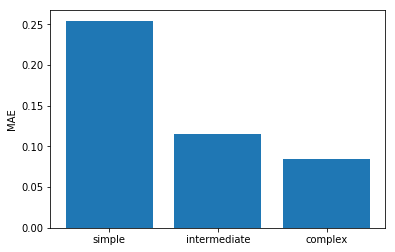

In [223]:
# (C) Final comparison
# Baseline


# Bar plot
mae_values = [mae_lr_simple, mae_lr_intermediate, mae_lr_complex]
titles = ['simple', 'intermediate', 'complex']

xcor = np.arange(len(mae_values))
plt.bar(xcor, mae_values)
plt.xticks(xcor, titles)

plt.ylabel('MAE')
plt.show()

## Computing predictions

In [730]:
test=pd.read_csv('/home/xavier/exts-ida/course3/house-prices/house-prices-test.csv')

In [672]:
miss = test.isnull().sum()/len(test)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

Mas Vnr Type      0.006
Mas Vnr Area      0.006
BsmtFin Type 2    0.018
Bsmt Qual         0.018
Bsmt Cond         0.018
Bsmt Exposure     0.018
BsmtFin Type 1    0.018
Garage Cond       0.042
Garage Qual       0.042
Garage Finish     0.042
Garage Type       0.042
Garage Yr Blt     0.042
Lot Frontage      0.140
Fireplace Qu      0.472
Fence             0.834
Alley             0.930
Misc Feature      0.968
Pool QC           0.998
dtype: float64

In [731]:
test["Mas Vnr Area"].fillna(0, inplace=True)
test["Mas Vnr Type"].fillna('None', inplace=True)
test["Bsmt Qual"].fillna('TA', inplace=True)
test["Bsmt Cond"].fillna('TA', inplace=True)
test["Bsmt Exposure"].fillna('No', inplace=True)
test["BsmtFin Type 1"].fillna('Unf', inplace=True)
test["BsmtFin Type 2"].fillna('Unf', inplace=True)
test["Garage Type"].fillna('Attchd', inplace=True)
test["Garage Cond"].fillna('TA', inplace=True)
test["Garage Finish"].fillna('Unf', inplace=True)
test["Bsmt Qual"].fillna('TA', inplace=True)
test["Bsmt Cond"].fillna('TA', inplace=True)
test["Fireplace Qu"].fillna('Gd', inplace=True)
test["Fence"].fillna('MnPrv', inplace=True)
test["Alley"].fillna('Grvl', inplace=True)
test["Garage Qual"].fillna('Attchd', inplace=True)
test["Misc Feature"].fillna('Shed', inplace=True)
test["Pool QC"].fillna('TA', inplace=True)
#test["SeasonSold"].fillna(0, inplace=True)

In [732]:
#The combined data set has 2915 rows and 81 columns. Now, we'll impute the LotFrontage variable. 
#impute lotfrontage by median of neighborhood
lot_frontage_by_neighborhood = test['Lot Frontage'].groupby(test['Neighborhood'])

for key, group in lot_frontage_by_neighborhood:
                idx = (test['Neighborhood'] == key) & (test['Lot Frontage'].isnull())
                test.loc[idx, 'Lot Frontage'] = group.median()

In [733]:
test["Garage Yr Blt"].fillna(np.nanmedian(test["Garage Yr Blt"]), inplace=True)

In [693]:
test.shape

(500, 81)

encoding , feature engineering

In [734]:
test = encode_ordinal(test)
test = cat_enc(test)
test = feat_col(test)

In [735]:
onehot_df = train_onehot(test)

In [736]:
test = test.join(onehot_df)

In [737]:
test.shape

(500, 367)

In [738]:
miss = test.isnull().sum()/len(test)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

SeasonSold    0.014
dtype: float64

In [739]:
test["SeasonSold"].fillna(0, inplace=True)

In [684]:
print('train shape :',train_pred.shape)
print('-----------')
print('test shape :',test_pred.shape)

train shape : (2389, 327)
-----------
test shape : (500, 327)


In [740]:
test_cp = test.copy()

In [741]:
#dropping some columns from the test data as they are not found in train
del test['_Exterior 2nd_Other']
del test['_Roof Matl_Roll']
del test['PID']
del test['Order']

In [742]:
#get numeric features
numeric_features = [f for f in test.columns if test[f].dtype != object]

#transform the numeric features using log(x + 1)
from scipy.stats import skew
skewed = test[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
test[skewed] = np.log1p(test[skewed])

In [743]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(test[numeric_features])
scaled = scaler.transform(test[numeric_features])

In [745]:
test_pred = test.select_dtypes(include=[np.number])
test_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 322 entries, MS SubClass to _Mo Sold_12
dtypes: float64(239), int32(21), int64(19), uint8(43)
memory usage: 1.0 MB


The difference in number of train and test columns suggests that some new features in the train data aren't available in the test data. Let's remove those variables and keep an equal number of columns in the train and test data.

In [751]:
# visualizing difference between train and test data
a=train_pred.columns.symmetric_difference(test_pred.columns)
a

Index(['_Garage Qual_Attchd'], dtype='object')

In [408]:
train_pred_cp = train_pred.copy()

In [748]:
drop_cols = ['_Bsmt Exposure_0', '_BsmtFin Type 1_0', '_BsmtFin Type 2_0',
'_Condition 2_Artery', '_Condition 2_PosA', '_Condition 2_RRAe','_Condition 2_RRAn', '_Condition 2_RRNn', '_Electrical_Mix',
'_Exter Cond_Ex', '_Exter Cond_Po', '_Exterior 1st_AsphShn','_Exterior 1st_BrkComm', '_Exterior 1st_CBlock',
'_Exterior 1st_ImStucc', '_Exterior 1st_PreCast', '_Exterior 1st_Stone','_Exterior 2nd_AsphShn', '_Exterior 2nd_PreCast', '_Fence_0',
'_Fireplace Qu_0', '_Foundation_Wood', '_Functional_2','_Garage Cond_Po', '_Garage Finish_0',
'_Garage Qual_Po', '_Heating_Floor', '_Kitchen Qual_Po','_Land Slope_Sev', '_MS SubClass_150', '_MS Zoning_A (agr)',
'_MS Zoning_I (all)', '_Misc Feature_Gar2', '_Misc Feature_TenC','_Neighborhood_Greens', '_Neighborhood_GrnHill',
'_Neighborhood_Landmrk', '_Pool QC_Ex', '_Pool QC_Fa','_Roof Matl_Membran', '_Roof Matl_Metal', '_Roof Matl_WdShngl',
'_Roof Style_Shed', '_Sale Type_Con', '_Sale Type_VWD']

train_pred.drop(drop_cols, axis=1, inplace=True)

/home/xavier/anaconda3/envs/exts-aml1/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [752]:
#del test_pred['_Garage Qual_Attchd'] 

In [493]:
#print('train shape :',train_pred.shape)
#print('-----------')
#print('test shape :',test_pred.shape)

train shape : (2389, 327)
-----------
test shape : (500, 327)


In [749]:
test_pred = test.select_dtypes(include=[np.number])
test_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 322 entries, MS SubClass to _Mo Sold_12
dtypes: float64(239), int32(21), int64(19), uint8(43)
memory usage: 1.0 MB


In [ ]:
del test_pred['_Garage Qual_Attchd'] 

In [753]:
print('train shape :',train_pred.shape)
print('-----------')
print('test shape :',test_pred.shape)

train shape : (2389, 321)
-----------
test shape : (500, 321)


In [754]:
miss = test_pred.isnull().sum()/len(test_pred)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

Series([], dtype: float64)

In [761]:
from sklearn.linear_model import LinearRegression

# Create a linear regression
lrc = LinearRegression()

# Fit it to train data
lrc.fit(train_pred, label_df['SalePrice'])
    
 # Compute predictions for test set
predictions = 10**lrc.predict(test_pred)


In [762]:
pred_df= pd.DataFrame.from_items([
    ('PID',test_cp['PID']),
    ('SalePrice',predictions)
])

In [763]:
pred_df.SalePrice.describe()

count       500.000000
mean      63295.117902
std       29257.535510
min        4329.511910
25%       42745.726939
50%       57409.304973
75%       78388.268592
max      235053.914901
Name: SalePrice, dtype: float64

In [383]:

miss = test_pred.isnull().sum()/len(test_pred)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

SeasonSold    0.014
dtype: float64

In [258]:
test_pred.dropna()

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Type,Mas Vnr Area,Exter Qual,...,_Mo Sold_3,_Mo Sold_4,_Mo Sold_5,_Mo Sold_6,_Mo Sold_7,_Mo Sold_8,_Mo Sold_9,_Mo Sold_10,_Mo Sold_11,_Mo Sold_12
0,50,66.0,11275,6,7,1932,1950,1,480.0,3,...,1,0,0,0,0,0,0,0,0,0
1,20,65.0,9757,5,7,1994,1994,2,0.0,3,...,0,0,0,0,0,0,0,1,0,0
2,60,86.0,11065,8,5,2006,2006,3,788.0,4,...,0,0,0,0,0,0,0,1,0,0
3,20,70.0,7000,5,7,1960,2002,1,45.0,3,...,0,1,0,0,0,0,0,0,0,0
4,50,66.0,8712,4,7,1900,1950,2,0.0,3,...,0,0,0,0,0,0,0,0,0,0
5,60,65.0,8453,6,5,1995,1995,1,38.0,4,...,0,1,0,0,0,0,0,0,0,0
6,30,72.0,9392,3,3,1900,1950,2,0.0,3,...,0,0,0,0,0,0,1,0,0,0
7,20,74.0,10530,6,5,1971,1971,2,0.0,3,...,1,0,0,0,0,0,0,0,0,0
8,20,134.0,17755,5,4,1959,1959,1,132.0,3,...,0,0,0,0,0,0,0,0,1,0
9,80,62.0,7692,4,6,1954,1954,2,0.0,3,...,0,0,0,0,0,0,0,0,1,0
